# architecture-17 ( Basic Classification ) v-1

## What's new:

1- Add


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical


2025-07-31 08:54:38.389270: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-31 08:54:38.463821: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753939478.486384    3664 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753939478.492075    3664 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-31 08:54:38.580878: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# 1- Load and Scaling Features

df = pd.read_csv('datasets-17/XAGUSD-H1-rates.csv', sep='\t').dropna()
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>']])

In [3]:

# 2- Label trend reversals (example: a simplistic method)

def label_trend_reversals(prices, window=5):
    labels = []
    for i in range(len(prices) - window):
        past = prices[i:i+window//2]
        future = prices[i+window//2:i+window]
        if np.mean(future) > np.mean(past):
            labels.append(1)  # potential buy
        elif np.mean(future) < np.mean(past):
            labels.append(2)  # potential sell
        else:
            labels.append(0)
    labels += [0] * window  # pad
    return labels

df['Label'] = label_trend_reversals(df['<CLOSE>'].values)


In [4]:
# 3- Prepare Sequences

SEQUENCE_LENGTH = 60
FORECAST_HORIZON = 10
X, y = [], []
for i in range(SEQUENCE_LENGTH, len(scaled_data) - FORECAST_HORIZON):
    X.append(scaled_data[i-SEQUENCE_LENGTH:i])
    y.append(df['Label'].iloc[i:i+FORECAST_HORIZON].values)

X, y = np.array(X), np.array(y)
print(f"X shape: {X.shape}, y shape: {y.shape}")  # Debug info

X shape: (55013, 60, 5), y shape: (55013, 10)


In [5]:
# 4- Split dataset

X_train = X[:-1]
y_train = y[:-1]
X_test = X[-1:]
y_test = np.array([to_categorical(y[-1], num_classes=3)])  # One-hot encode test label

In [6]:
# 5- One-hot encode each timestep's class (3 classes → depth = 3)

y_onehot = np.array([to_categorical(row, num_classes=3) for row in y_train])
# Now shape = (num_samples, 10, 3)


In [7]:
# 6- Build LSTM Classification Model

model = Sequential([
    Input(shape=(SEQUENCE_LENGTH, X.shape[2])),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(FORECAST_HORIZON * 3, activation='softmax'),
    tf.keras.layers.Reshape((FORECAST_HORIZON, 3))
])


I0000 00:00:1753939507.551818    3664 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1541 MB memory:  -> device: 0, name: NVIDIA GeForce MX330, pci bus id: 0000:02:00.0, compute capability: 6.1


In [8]:
# 7- Compile model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [9]:
# 8- Fit model

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train,
    y_onehot,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50


I0000 00:00:1753939517.428057    3728 cuda_dnn.cc:529] Loaded cuDNN version 91001


774/774 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.4946 - loss: 0.7577 - val_accuracy: 0.5038 - val_loss: 0.6965
Epoch 2/50
774/774 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5011 - loss: 0.7012 - val_accuracy: 0.4973 - val_loss: 0.6962
Epoch 3/50
774/774 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4990 - loss: 0.7000 - val_accuracy: 0.5002 - val_loss: 0.6962
Epoch 4/50
774/774 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4990 - loss: 0.7003 - val_accuracy: 0.4969 - val_loss: 0.6963
Epoch 5/50
774/774 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4987 - loss: 0.6999 - val_accuracy: 0.4959 - val_loss: 0.6963
Epoch 6/50
774/774 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5002 - loss: 0.6996 - val_accuracy: 0.4958 - val_loss: 0.6962
Epoch 7/50
774/774 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5002 - loss: 0.6999 - val_accuracy: 0.4973 - val_loss: 0.6964
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


In [10]:
# 9- Load the last 60 candles from a CSV file

input_df = pd.read_csv(
    'datasets-17/new-data-for-test/rows-60-from-20240503/rows-60-from-20240503.csv',
    sep='\t'
).dropna()

# 9-1 Combine <DATE> and <TIME> into a datetime column
input_df['DATETIME'] = pd.to_datetime(input_df['<DATE>'] + ' ' + input_df['<TIME>'])

# 9-2 Prepare features and scale
input_features = input_df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>']]
input_scaled = scaler.transform(input_features)  # Use the same scaler from training

# 9-3 Reshape for model: (1, 60, num_features)
input_sequence = np.expand_dims(input_scaled, axis=0)

# 9-4 Predict class probabilities
pred_probs = model.predict(input_sequence)  # e.g. shape: (1, 10 * 3)
forecast_horizon = 10
pred_classes = np.argmax(pred_probs.reshape(forecast_horizon, 3), axis=1)
print("Predicted Classes:", pred_classes)  # 0=no signal, 1=buy, 2=sell

# 9-5 Generate future timestamps
last_timestamp = input_df['DATETIME'].iloc[-1]
forecast_datetimes = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1),
                                   periods=forecast_horizon, freq='h')

# 9-6 Create predicted_df for plotting
predicted_df = pd.DataFrame({
    'DATETIME': forecast_datetimes,
    'forecast_class': pred_classes
})

# 9-7 Convert class → label
def class_to_label(c):
    return 'buy' if c == 1 else 'sell' if c == 2 else None

predicted_df['label'] = predicted_df['forecast_class'].apply(class_to_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Predicted Classes: [2 2 2 2 2 1 1 1 2 2]


# plot section

In [11]:
# 10- Plot section

import sys

sys.path.insert(1, '../utils')
import forex_plot_utils
import os
import pandas as pd

# 10-1 PARAMETERS
csv1_path = 'datasets-17/new-data-for-test/rows-60-from-20240503/latest-4-for-history.csv'
csv3_path = 'datasets-17/new-data-for-test/rows-60-from-20240503/after.csv'
plot_title = 'Write a suitable title.'
output_plot_path = None  # e.g., 'output.png'

# 10-2 LOAD DATA FROM CSVS
historical_df = forex_plot_utils.load_csv_with_datetime(csv1_path) if os.path.exists(csv1_path) else None
actual_future_df = forex_plot_utils.load_csv_with_datetime(csv3_path) if os.path.exists(csv3_path) else None
# 10-3 Generate forecast timestamps ===
# Start 1 hour after the last actual candle
last_timestamp = input_df['DATETIME'].iloc[-1]
forecast_datetimes = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=forecast_horizon, freq='h')

# 10-4 Create predicted_df with forecasted trend reversals
predicted_df = pd.DataFrame({
    'DATETIME': forecast_datetimes,
    'forecast_class': pred_classes
})

# 10-5 Optional: Add labels for plotting
def class_to_label(c):
    if c == 1:
        return 'buy'
    elif c == 2:
        return 'sell'
    else:
        return None

predicted_df['label'] = predicted_df['forecast_class'].apply(class_to_label)


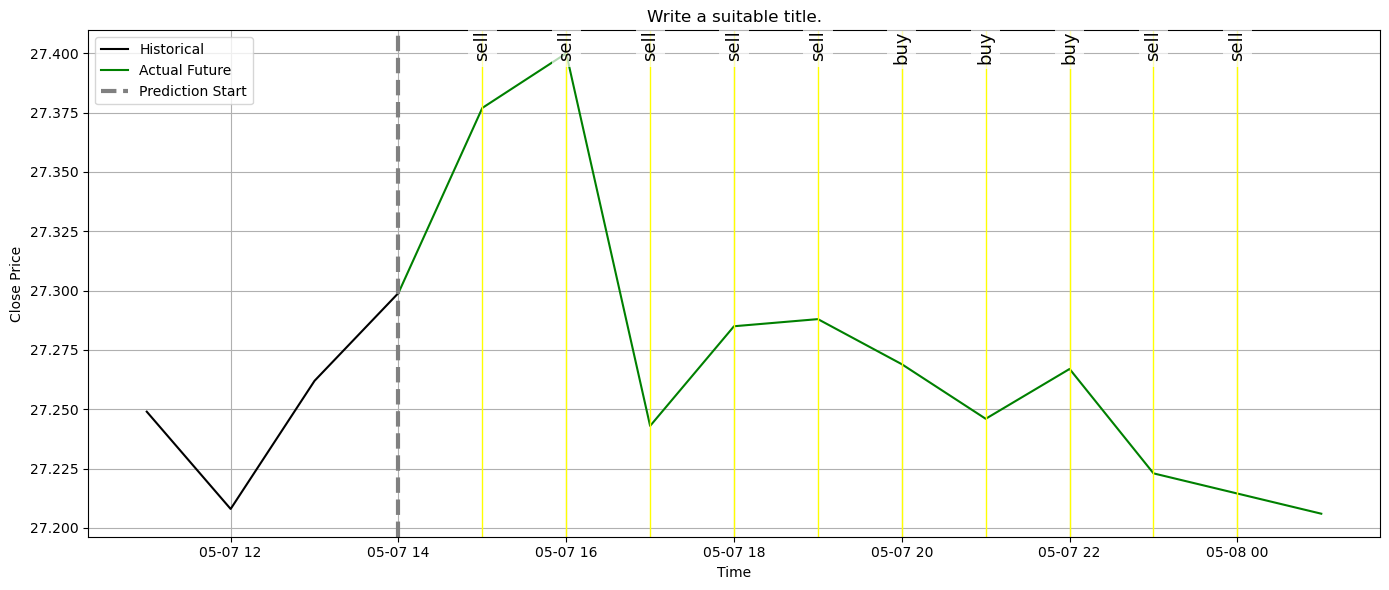

In [12]:
# 10-6 PLOT

forex_plot_utils.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)

In [13]:
# 11- Save Model

from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt

# 11-1 Create timestamp and paths
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_{timestamp}.keras'
model_path = os.path.join('saved_models', model_filename)

# 11-2 Directory to hold logs and extras
log_dir = os.path.join('saved_models', f'model_{timestamp}_logs')
os.makedirs(log_dir, exist_ok=True)

# 11-3 Save model
model.save(model_path)

# 11-4 Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(log_dir, 'training_history.csv'), index=False)

# 11-5 Save training loss plot
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(log_dir, 'training_loss.png'))
plt.close()

# 11-6 Save model summary and final performance
with open(os.path.join(log_dir, 'model_log.txt'), 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    final_train_loss = history.history['loss'][-1]
    final_test_loss, final_test_mae = model.evaluate(X_test, y_test, verbose=0)
    f.write(f'\nFinal Training Loss: {final_train_loss:.6f}\n')
    f.write(f'Final Test Loss: {final_test_loss:.6f}\n')
    f.write(f'Final Test MAE : {final_test_mae:.6f}\n')
